In [1]:
import kaggle

kaggle.api.dataset_download_files('manjilkarki/deepfake-and-real-images', path='/datasets/', unzip=True)


## Imports Packages

In [1]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import json

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, MaxPooling2D, LeakyReLU, BatchNormalization, Input
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from sklearn.metrics import mean_squared_error, r2_score
import unittest



tf.__version__: 2.15.0
keras.__version__: 2.15.0


C:\Users\borov\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load Train Data

In [2]:
# import data
image_paths = []
commands = []
train_dir = './datasets/Dataset/Train/'
test_dir = './datasets/Dataset/Test/'
validation_dir = './datasets/Dataset/Validation/'
model_output_dir = '.'

for image in os.listdir(os.path.join(test_dir, 'Real/')):
    image_paths.append(os.path.join(test_dir, 'Real/', image))
    commands.append(1)

for image in os.listdir(os.path.join(test_dir, 'Fake/')):
    image_paths.append(os.path.join(test_dir, 'Fake/', image))
    commands.append(0)

df = pd.DataFrame()
df['image_path'] = image_paths
df['command'] = commands
print('Data loaded!')

Data loaded!


In [3]:
# tests
def load_image(file_path):
    try:
        with open(file_path, 'rb') as file:
            img = Image.open(file)
            return img
    except Exception as e:
        print(f'Error loading image: {e}')
        return None
    

class TestDataLoading(unittest.TestCase):

    def setUp(self):
        self.real_photo_dir = './datasets/Dataset/Train/real'
        self.deepfake_photo_dir = './datasets/Dataset/Train/fake'
        self.num_files_to_test = 100

    def test_image_paths(self):
        #random 
        real_photos = random.sample(os.listdir(self.real_photo_dir), self.num_files_to_test)
        deepfake_photos = random.sample(os.listdir(self.deepfake_photo_dir), self.num_files_to_test)

        #Check file existing
        for photo in real_photos:
            photo_path = os.path.join(self.real_photo_dir, photo)
            self.assertTrue(os.path.exists(photo_path), f'File not found: {photo_path}')

        for photo in deepfake_photos:
            photo_path = os.path.join(self.deepfake_photo_dir, photo)
            self.assertTrue(os.path.exists(photo_path), f'File not found: {photo_path}')

    def test_image_loading(self):
        real_photos = random.sample(os.listdir(self.real_photo_dir), self.num_files_to_test)
        deepfake_photos = random.sample(os.listdir(self.deepfake_photo_dir), self.num_files_to_test)

        # Check if image is correct
        for photo in real_photos:
            photo_path = os.path.join(self.real_photo_dir, photo)
            loaded_photo = load_image(photo_path)
            self.assertIsNotNone(loaded_photo, f'Failed to load image: {photo_path}')

        for photo in deepfake_photos:
            photo_path = os.path.join(self.deepfake_photo_dir, photo)
            loaded_photo = load_image(photo_path)
            self.assertIsNotNone(loaded_photo, f'Failed to load image: {photo_path}')

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 3.157s

OK


In [4]:
#Nvidia Model
class NvidiaModel(Sequential):
    def __init__(self):
        super(NvidiaModel, self).__init__(name='Nvidia_Model')
        self._build_model()

    def _build_model(self):
        # Convolution Layers
        self.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(300, 400, 3), activation='elu')) 
        self.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
        self.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
        self.add(Conv2D(64, (3, 3), activation='elu')) 
        self.add(Dropout(0.2))  # not in the original model, added for more robustness
        self.add(Conv2D(64, (3, 3), activation='elu')) 

        # Fully Connected Layers
        self.add(Flatten())
        self.add(Dropout(0.2))  # not in the original model, added for more robustness
        self.add(Dense(100, activation='elu'))
        self.add(Dense(50, activation='elu'))
        self.add(Dense(10, activation='elu'))

        # Output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
        self.add(Dense(1)) 

        # Since this is a regression problem not classification problem,
        # we use MSE (Mean Squared Error) as the loss function
        optimizer = Adam(learning_rate=1e-3)  # lr is the learning rate
        self.compile(loss='mse', optimizer=optimizer)
    
    def fit(self, *args, **kwargs):
        return super(NvidiaModel, self).fit(*args, **kwargs)

In [5]:
#Meso4 Model
class Meso4(Sequential):
     def __init__(self):
        super(Meso4, self).__init__(name='Meso4_Model')
        self._build_model()
     
     def _build_model(self):
        # First block
        self.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

        # Second block
        self.add(Conv2D(8, (5, 5), padding='same', activation='relu'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

        # Third block
        self.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

        # Fourth block
        self.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

        # Fully Connected Layers
        self.add(Flatten())
        self.add(Dropout(0.5))
        self.add(Dense(16))
        self.add(LeakyReLU(alpha=0.1))
        self.add(Dropout(0.5))
        self.add(Dense(1, activation='sigmoid'))

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        self.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
        

     def fit(self, *args, **kwargs):
         return super(Meso4, self).fit(*args, **kwargs)
    

In [6]:
class ImageProcessor:
    @staticmethod
    def imread(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scale_percent = 80
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        return resized

    @staticmethod
    def img_preprocess(image):
        height, _, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (400, 300))
        image = image / 255
        return image
    
    @staticmethod
    def img_preprocess_meso4(image):
        height, _, _ = image.shape
        image = cv2.resize(image, (256,256))
        image = image / 255
        return image
    
    @staticmethod
    def imread(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scale_percent = 5 # percent of original size
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        return resized
    @staticmethod
    def my_imread(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scale_percent = 80 # percent of original size
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        return resized

    @staticmethod
    def image_data_generator(image_paths, commands, batch_size, is_training):
        while True:
            batch_images = []
            batch_commands = []
        
            for i in range(batch_size):
                random_index = random.randint(0, len(image_paths) - 1)
                image_path = image_paths[random_index]
                image = ImageProcessor.my_imread(image_paths[random_index])
                command = commands[random_index]
                image = ImageProcessor.img_preprocess(image)
                batch_images.append(image)
                batch_commands.append(command)
            
            yield( np.asarray(batch_images), np.asarray(batch_commands))
            
    @staticmethod        
    def image_data_generator_meso4(image_paths, commands, batch_size, is_training):
        while True:
            batch_images = []
            batch_commands = []
        
            for i in range(batch_size):
                random_index = random.randint(0, len(image_paths) - 1)
                image_path = image_paths[random_index]
                image = ImageProcessor.my_imread(image_paths[random_index])
                command = commands[random_index]
                image = ImageProcessor.img_preprocess_meso4(image)
                batch_images.append(image)
                batch_commands.append(command)
            
            yield( np.asarray(batch_images), np.asarray(batch_commands))
     
            
    @staticmethod
    def learnNvidiaModel():
        checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'deepfake_classifier_nvidia.h5'), verbose=1, save_best_only=True)
        print("deepfake classifier train started")
        history = model.fit(image_data_generator( X_train, y_train, batch_size=200, is_training=True),
                              steps_per_epoch=600,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=200, is_training=False),
                              validation_steps=400,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
        # always save model output as soon as model finishes training
        model.save(os.path.join(model_output_dir,'deepfake_classifier_nvidia.h5'))

        date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
        history_path = os.path.join(model_output_dir,'history_nvidia.pickle')
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
        print("deepfake classifier train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))
     
    @staticmethod
    def learnMeso4Model():
        checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'deepfake_classifier_meso4.h5'), verbose=1, save_best_only=True)
        print("deepfake classifier train started")
        history = model.fit(ImageProcessor.image_data_generator_meso4( X_train, y_train, batch_size=200, is_training=True),
                              steps_per_epoch=600,
                              epochs=10,
                              validation_data = ImageProcessor.image_data_generator_meso4( X_valid, y_valid, batch_size=200, is_training=False),
                              validation_steps=400,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
        # always save model output as soon as model finishes training
        model.save(os.path.join(model_output_dir,'deepfake_classifier_meso4.h5'))

        date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
        history_path = os.path.join(model_output_dir,'history_meso4.pickle')
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
        print("deepfake classifier train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))
    
    @staticmethod
    def summarize_prediction(Y_true, Y_pred):
    
        mse = mean_squared_error(Y_true, Y_pred)
        r_squared = r2_score(Y_true, Y_pred)
    
        print(f'mse       = {mse:.2}')
        print(f'r_squared = {r_squared:.2%}')
        print()
    
    @staticmethod
    def predict_and_summarize(X, Y):
        model = load_model(f'{model_output_dir}/deepfake_classifier_nvidia.h5')
        Y_pred2 = []
        Y_pred = model.predict(X)
        for y in Y_pred:
            Y_pred2.append(y)
        ImageProcessor.summarize_prediction(Y, Y_pred2)
        # for y in zip(Y, Y_pred):
        #     print(y)
        return Y_pred
    
    @staticmethod
    def predict_and_summarize_meso4(X, Y):
        model = load_model(f'{model_output_dir}/deepfake_classifier_meso4.h5')
        Y_pred2 = []
        Y_pred = model.predict(X)
        for y in Y_pred:
            Y_pred2.append(y)
        ImageProcessor.summarize_prediction(Y, Y_pred2)
        # for y in zip(Y, Y_pred):
        #     print(y)
        return Y_pred

(array([5492.0000, 5413.0000]),
 array([0.0000, 0.5000, 1.0000]),
 <BarContainer object of 2 artists>)

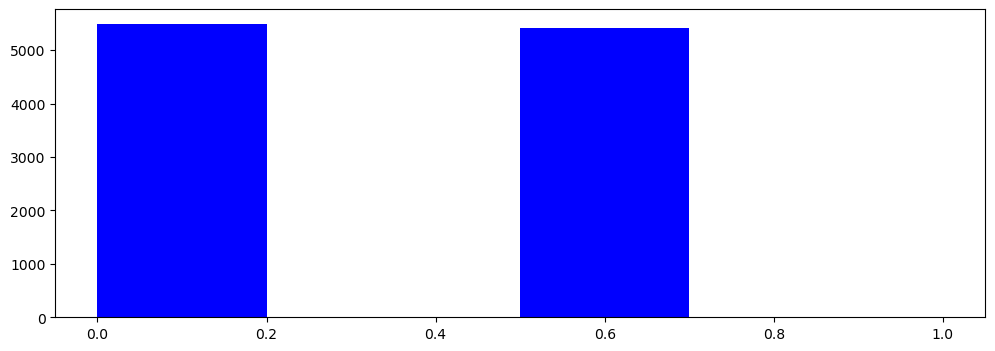

In [7]:
# Look at the distribution of commands
# distribution has to be balanced
num_of_bins = 2

hist, bins = np.histogram(df['command'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['command'], bins=num_of_bins, width=0.2, color='blue')

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, commands, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))


Training data: 8724
Validation data: 2181


## Create and Train Model

In [9]:
model = NvidiaModel()
# Print the model summary
print(model.summary())


Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 198, 24)      1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 97, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 47, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 45, 64)        27712     
                                                                 
 dropout (Dropout)           (None, 32, 45, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 43, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 82560)           

In [10]:
#Meso4 Model
Meso4Model = Meso4()
print(Meso4Model.summary())


Model: "Meso4_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)       0         
 D)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 8)       32        
 chNormalization)                                                
                                                      

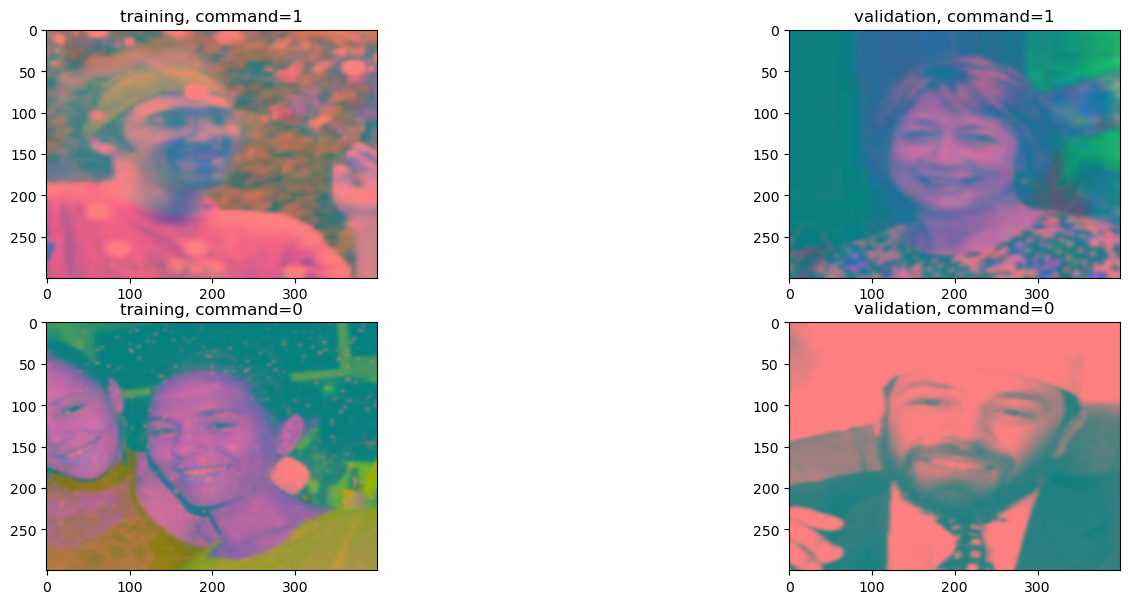

In [11]:
#Nvidia Model
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(ImageProcessor.image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(ImageProcessor.image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, command=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, command=%s" % y_valid_batch[i])


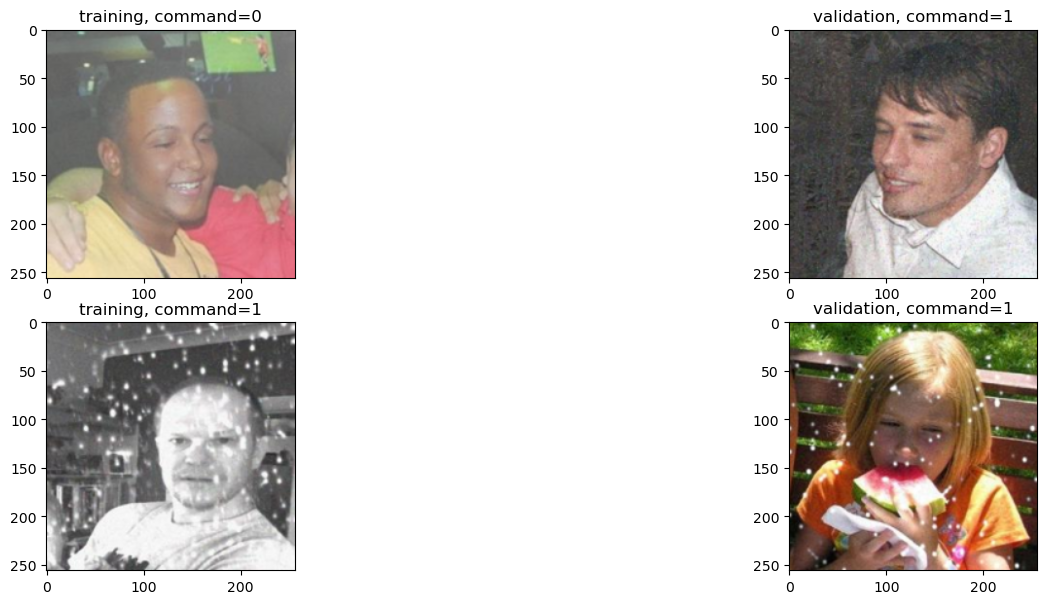

In [12]:
#Meso4 Model
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(ImageProcessor.image_data_generator_meso4(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(ImageProcessor.image_data_generator_meso4(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, command=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, command=%s" % y_valid_batch[i])


Comparing Nvidia Model and Meso4 Model

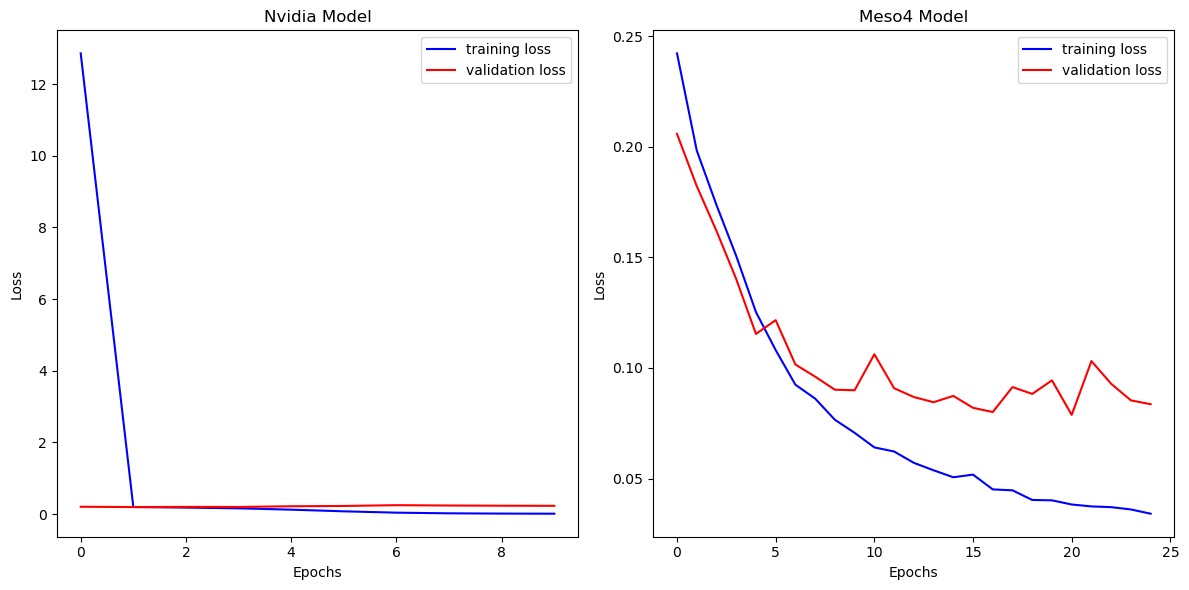

In [13]:
history_path = os.path.join(model_output_dir, 'history_nvidia.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Meso4 Model
history_path1 = os.path.join(model_output_dir, 'history_meso4.pickle')
with open(history_path1, 'rb') as f:
    history1 = pickle.load(f)

# Plot for Nvidia Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.title('Nvidia Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["training loss", "validation loss"])

# Plot for Meso4 Model
plt.subplot(1, 2, 2)
plt.plot(history1['loss'], color='blue')
plt.plot(history1['val_loss'], color='red')
plt.title('Meso4 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["training loss", "validation loss"])

plt.tight_layout()
plt.show()

In [17]:
#Nvidia Model
n_tests = 1000
X_test, y_test = next(ImageProcessor.image_data_generator(X_valid, y_valid, n_tests, False))

y_pred = ImageProcessor.predict_and_summarize(X_test, y_test)

32/32 [==============================] - 3s 71ms/step
mse       = 0.049
r_squared = 80.52%



In [20]:
#Meso4 Model
n_tests1 = 1000
X_test1, y_test1 = next(ImageProcessor.image_data_generator_meso4(X_valid, y_valid, n_tests1, False))

y_pred1 = ImageProcessor.predict_and_summarize_meso4(X_test1, y_test1)

32/32 [==============================] - 2s 42ms/step
mse       = 0.025
r_squared = 90.02%



==========================Nvidia Model==========================


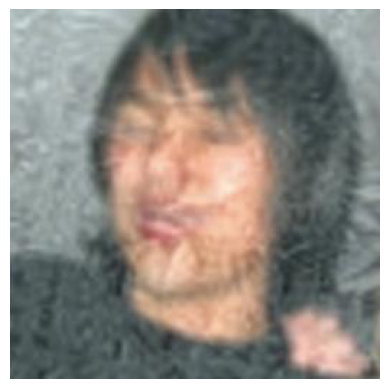

1/1 [==============================] - 0s 103ms/step
The likelihood that the image is real: 2.28%
Image - fake
==========================Meso4 Model==========================


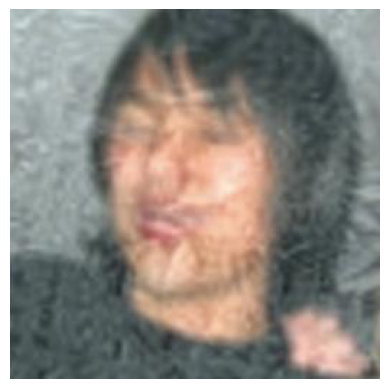

1/1 [==============================] - 0s 141ms/step
The likelihood that the image is real: 29.85%
Image - fake


In [16]:
#Nvidia Model
print('==========================Nvidia Model==========================')
img_path = f'{test_dir}/Fake/fake_5400.jpg';
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off') 
plt.show()

model = load_model(f'{model_output_dir}/deepfake_classifier_nvidia.h5')
X = np.array([ImageProcessor.img_preprocess(ImageProcessor.imread(img_path))])
Y_pred = model.predict([X])
print(f'The likelihood that the image is real: {Y_pred[0][0] * 100:.2f}%')
if(Y_pred.round() == 1):
    print('Image - real')
else:
    print('Image - fake')
    
    
    
#Meso4 Model
print('==========================Meso4 Model==========================')
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

model = load_model(f'{model_output_dir}/deepfake_classifier_meso4.h5')
X1 = np.array([ImageProcessor.img_preprocess_meso4(ImageProcessor.imread(img_path))])
Y_pred1 = model.predict([X1])
print(f'The likelihood that the image is real: {Y_pred1[0][0] * 100:.2f}%')
if(Y_pred1.round() == 1):
    print('Image - real')
else:
    print('Image - fake')